1. Download and load the data. Perform the initial exploration and cleaning.
   - it is already split into training and testing parts
   - labels go from 0 to 76
   - checks should include e.g.:
     - checking data types, number of texts,
     - plotting the class distribution
     - plotting the histogram of text lengths


In [1]:
from datasets import load_dataset
import polars as pl
import matplotlib.pyplot as plt

dataset = load_dataset("PolyAI/banking77", trust_remote_code=True)

train_df = pl.from_pandas(dataset["train"].to_pandas())
test_df = pl.from_pandas(dataset["test"].to_pandas())

In [2]:
train_df.shape

(10003, 2)

In [3]:
test_df.shape

(3080, 2)

In [4]:
train_df.describe

<bound method DataFrame.describe of shape: (10_003, 2)
┌─────────────────────────────────┬───────┐
│ text                            ┆ label │
│ ---                             ┆ ---   │
│ str                             ┆ i64   │
╞═════════════════════════════════╪═══════╡
│ I am still waiting on my card?  ┆ 11    │
│ What can I do if my card still… ┆ 11    │
│ I have been waiting over a wee… ┆ 11    │
│ Can I track my card while it i… ┆ 11    │
│ How do I know if I will get my… ┆ 11    │
│ …                               ┆ …     │
│ You provide support in what co… ┆ 24    │
│ What countries are you support… ┆ 24    │
│ What countries are getting sup… ┆ 24    │
│ Are cards available in the EU?  ┆ 24    │
│ Which countries are represente… ┆ 24    │
└─────────────────────────────────┴───────┘>

Text(0.5, 1.0, 'Class Distribution')

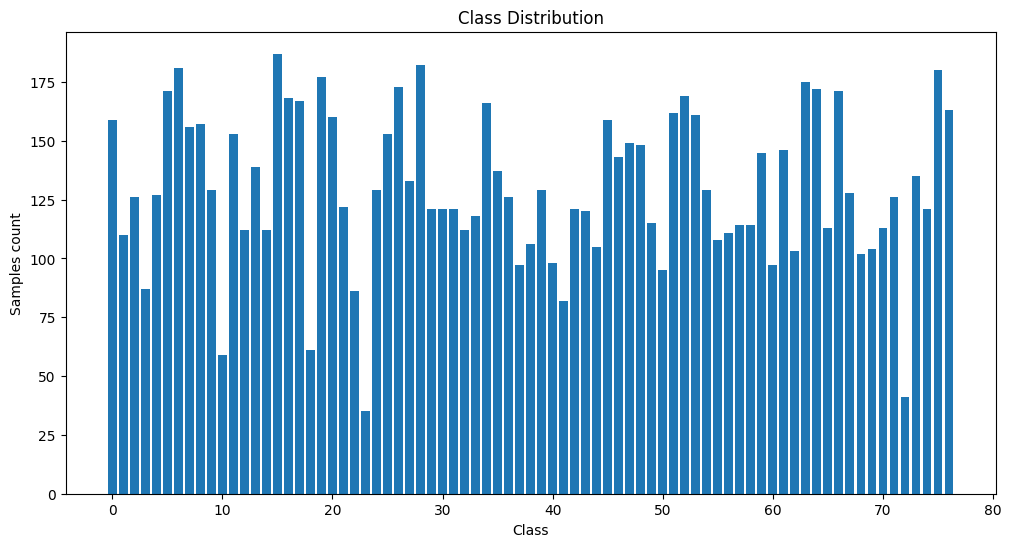

In [5]:
class_counts = train_df.group_by("label").agg(pl.len()).to_pandas()

plt.figure(figsize=(12, 6))
plt.bar(class_counts["label"], class_counts["len"])
plt.xlabel("Class")
plt.ylabel("Samples count")
plt.title("Class Distribution")

Text(0.5, 1.0, 'Text Lengths')

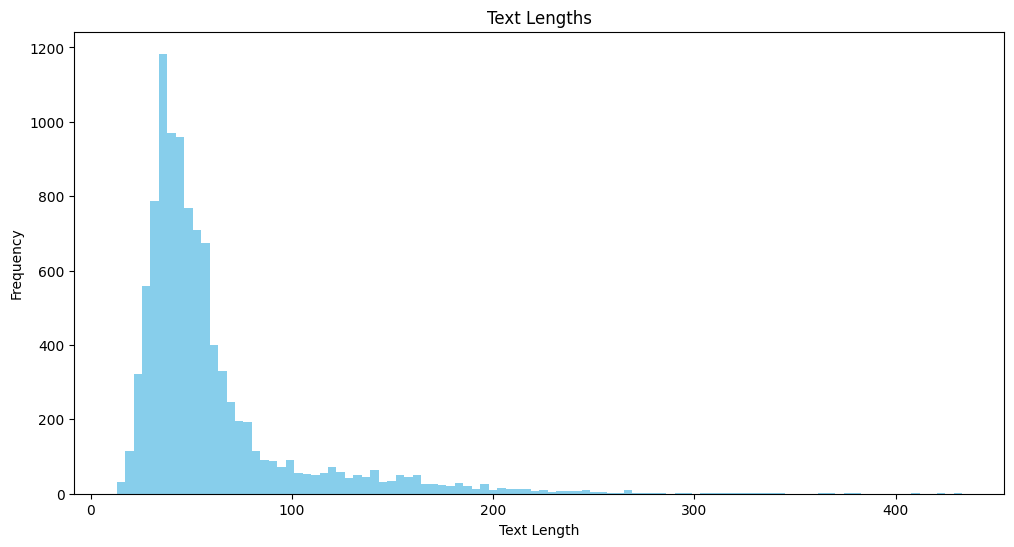

In [6]:
text_lengths = train_df["text"].str.len_chars()

plt.figure(figsize=(12, 6))
plt.hist(text_lengths, bins=100, color="skyblue")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.title("Text Lengths")

2. Use CleanLab to detect and fix data quality issues:
   - use `all-MiniLM-L6-v2` Sentence Transformer embeddings + logistic regression as the model
   - note that `LogisticRegressionCV` works out-of-the-box for multiclass classification, and
     you should use `class_weight="balanced"` in case of class imbalance
   - detect and fix: label issues, near duplicates, outliers
   - when analyzing duplicates, you can print rows at given indices with `.iloc[]`
   - comment:
     - do your results agree with [the paper](https://aclanthology.org/2022.insights-1.19/)
       pointing out the label quality issues?
     - are the problems severe and worth fixing in your opinion?


In [7]:
import joblib
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict


def get_initial_model_data(
    texts: np.ndarray, labels: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = model.encode(texts, show_progress_bar=True, convert_to_numpy=True)

    lr = LogisticRegression(max_iter=1000, class_weight="balanced", n_jobs=-1)
    pred_probs = cross_val_predict(
        lr, embeddings, labels, cv=5, method="predict_proba", n_jobs=-1
    )

    return embeddings, pred_probs

In [8]:
texts = train_df["text"]
labels = train_df["label"]

embeddings, pred_probs = get_initial_model_data(texts, labels)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

In [9]:
from cleanlab import Datalab

data_dict = {"texts": texts, "labels": labels}
lab = Datalab(data_dict, label_name="labels", task="classification")
lab.find_issues(pred_probs=pred_probs, features=embeddings)
lab.report()

Finding null issues ...
Finding label issues ...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Finding outlier issues ...
Finding near_duplicate issues ...
Finding non_iid issues ...
Finding class_imbalance issues ...
Finding underperforming_group issues ...

Audit complete. 648 issues found in the dataset.
Dataset Information: num_examples: 10003, num_classes: 77

Here is a summary of various issues found in your data:

    issue_type  num_issues
near_duplicate         350
         label         166
       outlier         131
       non_iid           1

Learn about each issue: https://docs.cleanlab.ai/stable/cleanlab/datalab/guide/issue_type_description.html
See which examples in your dataset exhibit each issue via: `datalab.get_issues(<ISSUE_NAME>)`

Data indices corresponding to top examples of each issue are shown below.


------------------ near_duplicate issues -------------------

About this issue:
	A (near) duplicate issue refers to two or more examples in
    a dataset that are extremely similar to each other, relative
    to the rest of the dataset.  The examples flagg

### Duplicates


In [10]:
duplicate_issues = lab.get_issues("near_duplicate")
duplicate_issues = duplicate_issues[duplicate_issues["is_near_duplicate_issue"]]
duplicate_issues = duplicate_issues.sort_values(by="near_duplicate_score")

duplicate_issues.head(10)

,is_near_duplicate_issue,near_duplicate_score,near_duplicate_sets,distance_to_nearest_neighbor
1724,True,0.0,[1710],0.0
1246,True,0.0,[1290],0.0
6910,True,0.0,[6965],0.0
1290,True,0.0,[1246],0.0
5922,True,0.0,"[5930, 5921]",0.0
6965,True,0.0,[6910],0.0
5930,True,0.0,"[5922, 5921]",0.0
4595,True,0.0,[4594],0.0
4915,True,0.0,"[4903, 4839]",0.0
4903,True,0.0,"[4915, 4839]",0.0


In [11]:
for idx, row in duplicate_issues.head(10).iterrows():
    text = texts[idx]
    neighbors = texts[row["near_duplicate_sets"][:3]]
    print("---")
    print(f"Text: {text}")
    print(f"Duplicates: {neighbors}")

---
Text: I put the wrong pin too many times and now it is blocked. Can you help me unblock it?
Duplicates: shape: (1,)
Series: 'text' [str]
[
	"
I put the wrong pin too many …
]
---
Text: I can't seem to be able to use my card
Duplicates: shape: (1,)
Series: 'text' [str]
[
	"
I can't seem to be able to us…
]
---
Text: Do I need to go to a physical bank to change my PIN?
Duplicates: shape: (1,)
Series: 'text' [str]
[
	"
Do I need to go to a physical…
]
---
Text: 
I can't seem to be able to use my card



Duplicates: shape: (1,)
Series: 'text' [str]
[
	"I can't seem to be able to use…
]
---
Text: Why do you keep declining my payment? I tried several times already with this card and it is just not working.
Duplicates: shape: (2,)
Series: 'text' [str]
[
	"Why do you keep declining my p…
	"Why do you keep declining my p…
]
---
Text: 
Do I need to go to a physical bank to change my PIN?
Duplicates: shape: (1,)
Series: 'text' [str]
[
	"Do I need to go to a physical …
]
---
Text: Why do you k

In [12]:
for idx, row in duplicate_issues.tail(10).iterrows():
    text = texts[idx]
    neighbors = texts[row["near_duplicate_sets"][:3]]
    print("---")
    print(f"Text: {text}")
    print(f"Duplicates: {neighbors}")

---
Text: What do I do if I can't prove my identity?
Duplicates: shape: (1,)
Series: 'text' [str]
[
	"What should I do if I can't pr…
]
---
Text: How can I receive a virtual card?
Duplicates: shape: (1,)
Series: 'text' [str]
[
	"How do I receive a virtual car…
]
---
Text: How do I receive a virtual card?
Duplicates: shape: (1,)
Series: 'text' [str]
[
	"How can I receive a virtual ca…
]
---
Text: Can you please tell me why my transfer failed?
Duplicates: shape: (1,)
Series: 'text' [str]
[
	"Can you please explain why my …
]
---
Text: Can you please explain why my transfer failed?
Duplicates: shape: (1,)
Series: 'text' [str]
[
	"Can you please tell me why my …
]
---
Text: Is there a limit to using a disposable virtual card?
Duplicates: shape: (1,)
Series: 'text' [str]
[
	"Is there a limit to a disposab…
]
---
Text: Is there a limit to a disposable virtual card?
Duplicates: shape: (1,)
Series: 'text' [str]
[
	"Is there a limit to using a di…
]
---
Text: Can I top up any amount?
Duplicates

In [13]:
duplicate_issues.shape

(350, 4)

In [14]:
duplicate_indices = duplicate_issues.index.tolist()

df_deduplicated = (
    train_df.with_row_index(name="original_index")
    .filter(pl.col("original_index").is_in(duplicate_indices).not_())
    .to_pandas()
    .set_index("original_index", drop=True)
)

### Labels


In [15]:
CATEGORIES_LOOKUP = [
    "activate_my_card",
    "age_limit",
    "apple_pay_or_google_pay",
    "atm_support",
    "automatic_top_up",
    "balance_not_updated_after_bank_transfer",
    "balance_not_updated_after_cheque_or_cash_deposit",
    "beneficiary_not_allowed",
    "cancel_transfer",
    "card_about_to_expire",
    "card_acceptance",
    "card_arrival",
    "card_delivery_estimate",
    "card_linking",
    "card_not_working",
    "card_payment_fee_charged",
    "card_payment_not_recognised",
    "card_payment_wrong_exchange_rate",
    "card_swallowed",
    "cash_withdrawal_charge",
    "cash_withdrawal_not_recognised",
    "change_pin",
    "compromised_card",
    "contactless_not_working",
    "country_support",
    "declined_card_payment",
    "declined_cash_withdrawal",
    "declined_transfer",
    "direct_debit_payment_not_recognised",
    "disposable_card_limits",
    "edit_personal_details",
    "exchange_charge",
    "exchange_rate",
    "exchange_via_app",
    "extra_charge_on_statement",
    "failed_transfer",
    "fiat_currency_support",
    "get_disposable_virtual_card",
    "get_physical_card",
    "getting_spare_card",
    "getting_virtual_card",
    "lost_or_stolen_card",
    "lost_or_stolen_phone",
    "order_physical_card",
    "passcode_forgotten",
    "pending_card_payment",
    "pending_cash_withdrawal",
    "pending_top_up",
    "pending_transfer",
    "pin_blocked",
    "receiving_money",
    "Refund_not_showing_up",
    "request_refund",
    "reverted_card_payment?",
    "supported_cards_and_currencies",
    "terminate_account",
    "top_up_by_bank_transfer_charge",
    "top_up_by_card_charge",
    "top_up_by_cash_or_cheque",
    "top_up_failed",
    "top_up_limits",
    "top_up_reverted",
    "topping_up_by_card",
    "transaction_charged_twice",
    "transfer_fee_charged",
    "transfer_into_account",
    "transfer_not_received_by_recipient",
    "transfer_timing",
    "unable_to_verify_identity",
    "verify_my_identity",
    "verify_source_of_funds",
    "verify_top_up",
    "virtual_card_not_working",
    "visa_or_mastercard",
    "why_verify_identity",
    "wrong_amount_of_cash_received",
    "wrong_exchange_rate_for_cash_withdrawal",
]

In [16]:
texts = texts.to_pandas()

label_issues = lab.get_issues("label")
label_issues = label_issues[label_issues["is_label_issue"]].sort_values(
    by="label_score"
)
label_issues = label_issues[label_issues.index.isin(df_deduplicated.index)]

top_label_issues_y_true = label_issues.head(10)["given_label"]
top_label_issues_y_pred = label_issues.head(10)["predicted_label"]
top_label_issues_idxs = label_issues.head(10).index
top_label_issues_texts = texts[top_label_issues_idxs]

print("Top 10 label issues")
for text, y_true, y_pred in zip(
    top_label_issues_texts, top_label_issues_y_true, top_label_issues_y_pred
):
    print(
        f"y_true {CATEGORIES_LOOKUP[y_true]}, y_pred {CATEGORIES_LOOKUP[y_pred]}, text: {text}"
    )
    print()

Top 10 label issues
y_true pending_top_up, y_pred topping_up_by_card, text: i put money on my card and i dont see it on the balance

y_true disposable_card_limits, y_pred getting_virtual_card, text: i am not a premium customer but i want a virtual card, how do i get it

y_true declined_cash_withdrawal, y_pred card_not_working, text: Is my card actually working? It's the first time I tried using it

y_true transfer_into_account, y_pred topping_up_by_card, text: How do I top up?

y_true top_up_failed, y_pred declined_card_payment, text: My credit card transaction was declined for a loan payment.  Can you tell me why?

y_true pending_transfer, y_pred balance_not_updated_after_bank_transfer, text: I have not seen any changes in my account balance(s) after making a transfer.

y_true lost_or_stolen_card, y_pred card_arrival, text: Can you tell me the status of my new card?

y_true transfer_timing, y_pred balance_not_updated_after_bank_transfer, text: I just did a transfer, but don't see the 

There actually seems to be some errors with labels, some of the predicted labels make more sense.


I wanted to do this exercise using Polars, but I'm having some problems porting the code from the laboratories. To avoid rewriting the code I have already written, I decided to gradually move back to pandas, but I understand that it's not the cleanest solution.


In [17]:
label_issues = label_issues[label_issues.index.isin(df_deduplicated.index)]

idxs = label_issues.index.tolist()
pred_labels = label_issues["predicted_label"]

df_fixed = df_deduplicated.copy()
df_fixed.loc[label_issues.index, "label"] = label_issues["predicted_label"].values
df_fixed = df_fixed.reset_index(drop=True)
df_fixed

,text,label
0,I am still waiting on my card?,11
1,What can I do if my card still hasn't arrived ...,11
2,I have been waiting over a week. Is the card s...,11
3,Can I track my card while it is in the process...,11
4,"How do I know if I will get my card, or if it ...",11
...,...,...
9648,You provide support in what countries?,24
9649,What countries are you supporting?,24
9650,What countries are getting support?,24
9651,Are cards available in the EU?,24


### Outliers


In [18]:
outliers_issue = lab.get_issues("outlier")
outliers_issue = outliers_issue[outliers_issue["is_outlier_issue"]]
outliers_issue = outliers_issue.sort_values(by="outlier_score")

for idx, row in outliers_issue.head(20).iterrows():
    text = texts[idx]
    score = row["outlier_score"]
    print(f"Index: {idx}, Score: {score:.4f}")
    print(f"Text: {text}")
    print()

Index: 3107, Score: 0.0051
Text: WHAT IS THE ATMOSPHERE OF IT

Index: 4633, Score: 0.0063
Text: what is the word?

Index: 8802, Score: 0.0079
Text: What is this witdrawal

Index: 4655, Score: 0.0079
Text: what is the matter?

Index: 93, Score: 0.0087
Text: WHAT IS THE SOLUTION OF THIS PROBLEM

Index: 4104, Score: 0.0107
Text: I prefer Mastecard.

Index: 7432, Score: 0.0164
Text: I have made 5 attempts to make a very standard survey, yet I can't get it to work. What is the problem? Is there an issue related to your system?

Index: 1311, Score: 0.0167
Text: WHAT IS THE MAIN REASON OF THIS PROBLEM

Index: 1272, Score: 0.0168
Text: WHAT IS THE REASON FOR THAT

Index: 7218, Score: 0.0189
Text: why was i chargged

Index: 6082, Score: 0.0201
Text: I have a trasnger that is pending and wondered about it.

Index: 9898, Score: 0.0202
Text: As far as courtries go which ones are supported?

Index: 6971, Score: 0.0225
Text: How can I change my Rowlock ?

Index: 9920, Score: 0.0246
Text: Can I get s

For a dataset of this size outliers do not look this bad. Most of the texts here could be explained in my opinion. "why was i chargged", seems like a simple typo of a valid issue. I don't think it's worth to delete these.


3. Train a small text classifier:
   - you can use `distilbert/distilbert-base-uncased` model, or any other that you want
   - make 80-20% train-valid split
   - use F1-score to select the best model
   - perform hyperparameter tuning, or use larger learning rate and train for longer than in
     the lab, since the dataset is small and task is harder
   - modify how `y_pred_proba` and `y_pred` are returned to accommodate multiclass classification,
     `np.argmax()` may be useful


In [19]:
import torch
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

df_train, df_valid = train_test_split(
    df_fixed, train_size=0.8, random_state=0, stratify=df_fixed["label"]
)

datasets_dict = DatasetDict()
datasets_dict["train"] = Dataset.from_pandas(df_train, split="train")
datasets_dict["valid"] = Dataset.from_pandas(df_valid, split="valid")

In [20]:
from transformers import AutoTokenizer


tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")


def tokenize(examples: dict) -> dict:
    enc = tokenizer(examples["text"], padding=True, truncation=True)
    enc["label"] = torch.tensor(examples["label"])
    return enc


num_cores = joblib.cpu_count(only_physical_cores=True)
datasets_tokenized = datasets_dict.map(tokenize, batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/7722 [00:00<?, ? examples/s]

Map:   0%|          | 0/1931 [00:00<?, ? examples/s]

In [32]:
import os
import random

from sklearn.metrics import matthews_corrcoef, f1_score
from torch.nn.functional import softmax
from transformers import (
    AutoModelForSequenceClassification,
    EvalPrediction,
    Trainer,
    TrainingArguments,
)

os.environ["PYTHONHASHSEED"] = str(0)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=len(CATEGORIES_LOOKUP)
)

# for param in model.distilbert.embeddings.parameters():
#     param.requires_grad = False

# for param in model.distilbert.transformer.parameters():
#     param.requires_grad = False


def compute_metrics(eval_pred: EvalPrediction) -> dict:
    y_true = eval_pred.label_ids.ravel()
    y_pred = np.argmax(eval_pred.predictions, axis=1)
    f1 = f1_score(y_true, y_pred, average="macro")
    return {"F1": f1}


training_args = TrainingArguments(
    output_dir="finetuned_model",
    learning_rate=2e-5,
    num_train_epochs=5,
    eval_strategy="steps",
    save_steps=2000,
    eval_steps=500,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="F1",
    greater_is_better=True,
    seed=0,
    data_seed=0,
    fp16=True,  # comment this out if you have unsupported hardware
    # dataloader_num_workers=1,  # comment out if necessary
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=datasets_tokenized["train"],
    eval_dataset=datasets_tokenized["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    # label_names=["label"],
)
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,F1
500,3.644100,2.667142,0.509898
1000,2.163200,1.474074,0.728190
1500,1.186400,0.859539,0.809160
2000,0.755000,0.583534,0.865400
2500,0.458800,0.462457,0.875439
3000,0.333400,0.403255,0.882023
3500,0.236100,0.373069,0.896653
4000,0.188500,0.348271,0.900867
4500,0.151600,0.345083,0.903831


TrainOutput(global_step=4830, training_loss=0.9529158219047215, metrics={'train_runtime': 352.3469, 'train_samples_per_second': 109.58, 'train_steps_per_second': 13.708, 'total_flos': 954211402298724.0, 'train_loss': 0.9529158219047215, 'epoch': 5.0})

In [33]:
pred_output = trainer.predict(datasets_tokenized["valid"])
logits = torch.from_numpy(pred_output.predictions)
y_pred_proba = softmax(logits, dim=1).numpy()
y_pred = np.argmax(y_pred_proba, axis=1)
y_test = np.array(datasets_tokenized["valid"]["label"])

4. Test the resulting model:
   - check a few quality metrics
   - for multiclass metrics, use `average="macro"` (non-AUROC) or `multi_class="ovo"` (AUROC)
   - plot the F1-score for each class
   - comment:
     - is the overall F1-score comparable with the papers?
     - is it high enough from your perspective?
     - are there significant differences between classes?


In [34]:
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    f1_score,
)

acc = accuracy_score(y_test, y_pred)
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
    y_test, y_pred, average="macro", zero_division=0
)
auroc_macro_ovo = roc_auc_score(
    y_test, y_pred_proba, multi_class="ovo", average="macro"
)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec_macro:.4f}")
print(f"Recall: {rec_macro:.4f}")
print(f"F1: {f1_macro:.4f}")
print(f"AUROC: {auroc_macro_ovo:.4f}")

Accuracy: 0.9094
Precision: 0.9144
Recall: 0.8974
F1: 0.9009
AUROC: 0.9982


Text(0, 0.5, 'F1')

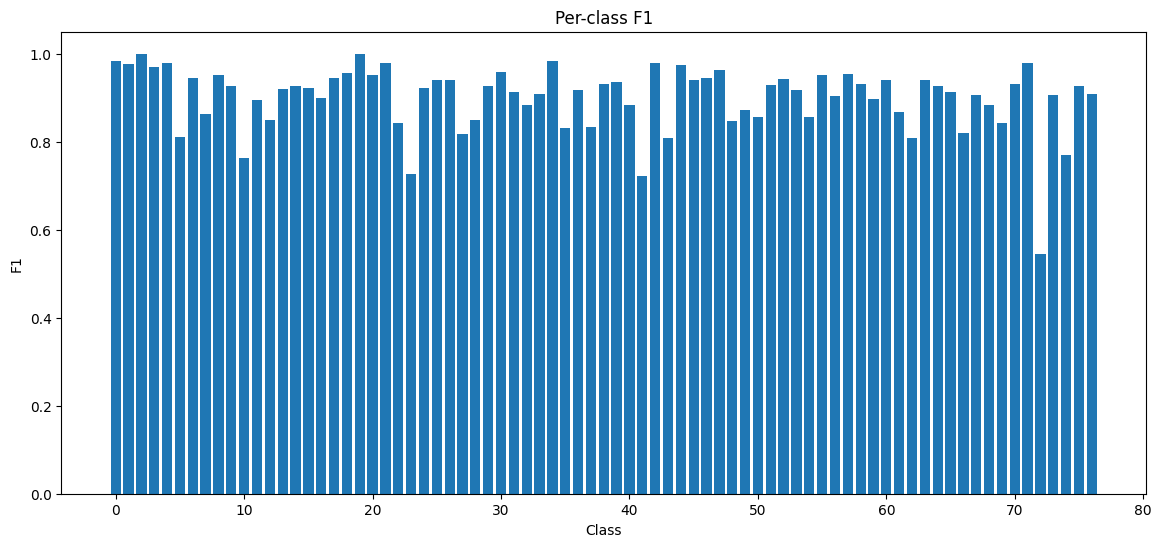

In [35]:
f1_per_class = f1_score(
    y_test, y_pred, labels=range(len(CATEGORIES_LOOKUP)), average=None
)

plt.figure(figsize=(14, 6))
plt.bar(range(len(CATEGORIES_LOOKUP)), f1_per_class)
plt.title("Per-class F1")
plt.xlabel("Class")
plt.ylabel("F1")

**Comment**

- is the overall F1-score comparable with the papers?

I had a lot of problems getting reasonable results. I tried multiple things, but the solution seemed to be to commount out gradient freezing that was done in the laboratories. For this example it sped up the training, but resulted in terrible metrics. After fixing it the model started to learn.

My overall score seems to surpas the results from the paper - LightGBM used in the paper got 0.882 accuracy vs my 0.909 accuracy.

- is it high enough from your perspective?

Yes, in my opinion it's very good score.

- are there significant differences between classes?

Despite a couple of distinct examples, most of the classes highlight very good and even f1 score.


5. Use Giskard for behavioral testing:
   - modify `prediction_function()` appropriately
   - HuggingFace pipeline has `top_k=None` option to get scores for all labels, not just the label
     with the highest probability
   - analyze the results, are there any additional problems with the resulting classifier?


In [36]:
from giskard import Model as GiskardModel, Dataset as GiskardDataset, scan, testing
from transformers import pipeline
import pandas as pd

trained_model = trainer.model
trained_model.eval()
model_pipeline = pipeline(
    "text-classification",
    model=trained_model,
    tokenizer=tokenizer,
    device="cuda" if torch.cuda.is_available() else "cpu",
)


@torch.no_grad()
def prediction_function(df: pd.DataFrame) -> np.ndarray:
    outputs = model_pipeline(df["text"].tolist(), top_k=None)
    proba = np.array(
        [
            [
                d["score"]
                for d in sorted(sample, key=lambda x: int(x["label"].split("_")[-1]))
            ]
            for sample in outputs
        ]
    )
    return proba


giskard_dataset = GiskardDataset(df_valid, target="label")

giskard_model = GiskardModel(
    model=prediction_function,
    model_type="classification",
    classification_labels=np.arange(len(CATEGORIES_LOOKUP)).tolist(),
    feature_names=["text"],
)
scan_results = scan(giskard_model, giskard_dataset, verbose=False)
display(scan_results)

Device set to use cuda


2025-11-21 10:40:47,198 pid:10871 MainThread giskard.datasets.base INFO     Your 'pandas.DataFrame' is successfully wrapped by Giskard's 'Dataset' wrapper class.
2025-11-21 10:40:47,200 pid:10871 MainThread giskard.models.automodel INFO     Your 'prediction_function' is successfully wrapped by Giskard's 'PredictionFunctionModel' wrapper class.
2025-11-21 10:40:47,232 pid:10871 MainThread giskard.datasets.base INFO     Casting dataframe columns from {'text': 'object'} to {'text': 'object'}
2025-11-21 10:40:47,329 pid:10871 MainThread giskard.utils.logging_utils INFO     Predicted dataset with shape (10, 2) executed in 0:00:00.119513
2025-11-21 10:40:47,340 pid:10871 MainThread giskard.datasets.base INFO     Casting dataframe columns from {'text': 'object'} to {'text': 'object'}
2025-11-21 10:40:47,350 pid:10871 MainThread giskard.utils.logging_utils INFO     Predicted dataset with shape (1, 2) executed in 0:00:00.018701
2025-11-21 10:40:47,360 pid:10871 MainThread giskard.datasets.base 

<iframe id="scan-124510778641872" srcdoc="<!doctype html>
<html lang="en">

<head>
 <title>Giskard Scan Results</title>
 <base target="_blank">
 <meta charset="utf-8">
 
<style>pre code.hljs{display:block;overflow-x:auto;padding:1em}code.hljs{padding:3px 5px}
/*!
 Theme: GitHub Dark
 Description: Dark theme as seen on github.com
 Author: github.com
 Maintainer: @Hirse
 Updated: 2021-05-15

 Outdated base version: https://github.com/primer/github-syntax-dark
 Current colors taken from GitHub's CSS
*/.hljs{background:#0d1117;color:#c9d1d9}.hljs-doctag,.hljs-keyword,.hljs-meta .hljs-keyword,.hljs-template-tag,.hljs-template-variable,.hljs-type,.hljs-variable.language_{color:#ff7b72}.hljs-title,.hljs-title.class_,.hljs-title.class_.inherited__,.hljs-title.function_{color:#d2a8ff}.hljs-attr,.hljs-attribute,.hljs-literal,.hljs-meta,.hljs-number,.hljs-operator,.hljs-selector-attr,.hljs-selector-class,.hljs-selector-id,.hljs-variable{color:#79c0ff}.hljs-meta .hljs-string,.hljs-regexp,.hljs-string{color:#a5d6ff}.hljs-built_in,.hljs-symbol{color:#ffa657}.hljs-code,.hljs-comment,.hljs-formula{color:#8b949e}.hljs-name,.hljs-quote,.hljs-selector-pseudo,.hljs-selector-tag{color:#7ee787}.hljs-subst{color:#c9d1d9}.hljs-section{color:#1f6feb;font-weight:700}.hljs-bullet{color:#f2cc60}.hljs-emphasis{color:#c9d1d9;font-style:italic}.hljs-strong{color:#c9d1d9;font-weight:700}.hljs-addition{background-color:#033a16;color:#aff5b4}.hljs-deletion{background-color:#67060c;color:#ffdcd7}.hljs-copy-wrapper{overflow:hidden;position:relative}.hljs-copy-button:focus,.hljs-copy-wrapper:hover .hljs-copy-button{transform:translateX(0)}.hljs-copy-button{background-color:#2d2b57;background-color:var(--hljs-theme-background);background-image:url('data:image/svg+xml;charset=utf-8,<svg xmlns="http://www.w3.org/2000/svg" width="16" height="16" fill="none" viewBox="0 0 24 24"><path fill="%23fff" fill-rule="evenodd" d="M6 5a1 1 0 0 0-1 1v14a1 1 0 0 0 1 1h12a1 1 0 0 0 1-1V6a1 1 0 0 0-1-1h-2a1 1 0 1 1 0-2h2a3 3 0 0 1 3 3v14a3 3 0 0 1-3 3H6a3 3 0 0 1-3-3V6a3 3 0 0 1 3-3h2a1 1 0 0 1 0 2H6Z" clip-rule="evenodd"/><path fill="%23fff" fill-rule="evenodd" d="M7 3a2 2 0 0 1 2-2h6a2 2 0 0 1 2 2v2a2 2 0 0 1-2 2H9a2 2 0 0 1-2-2V3Zm8 0H9v2h6V3Z" clip-rule="evenodd"/></svg>');background-position:50%;background-repeat:no-repeat;border:1px solid #ffffff22;border-radius:.25rem;color:#fff;height:2rem;position:absolute;right:1em;text-indent:-9999px;top:1em;transition:background-color .2s ease,transform .2s ease-out;width:2rem}.hljs-copy-button:hover{border-color:#ffffff44}.hljs-copy-button:active{border-color:#ffffff66}.hljs-copy-button[data-copied=true]{background-image:none;text-indent:0;width:auto}@media (prefers-reduced-motion){.hljs-copy-button{transition:none}}.hljs-copy-alert{clip:rect(0 0 0 0);-webkit-clip-path:inset(50%);clip-path:inset(50%);height:1px;overflow:hidden;position:absolute;white-space:nowrap;width:1px}
/*! tailwindcss v3.3.2 | MIT License | https://tailwindcss.com*/*,:after,:before{border:0 solid #e5e7eb;box-sizing:border-box}:after,:before{--tw-content:""}html{-webkit-text-size-adjust:100%;font-feature-settings:normal;font-family:ui-sans-serif,system-ui,-apple-system,BlinkMacSystemFont,Segoe UI,Roboto,Helvetica Neue,Arial,Noto Sans,sans-serif,Apple Color Emoji,Segoe UI Emoji,Segoe UI Symbol,Noto Color Emoji;font-variation-settings:normal;line-height:1.5;-moz-tab-size:4;-o-tab-size:4;tab-size:4}body{line-height:inherit;margin:0}hr{border-top-width:1px;color:inherit;height:0}abbr:where([title]){-webkit-text-decoration:underline dotted;text-decoration:underline dotted}h1,h2,h3,h4,h5,h6{font-size:inherit;font-weight:inherit}a{color:inherit;text-decoration:inherit}b,strong{font-weight:bolder}code,kbd,pre,samp{font-family:ui-monospace,SFMono-Regular,Menlo,Monaco,Consolas,Liberation Mono,Courier New,monospace;font-size:1em}small{font-size:80%}sub,sup{font-size:75%;line-height:0;position:relative;vertical-align:baseline}sub{bottom:-.25em}sup{top:-.5em}table{border-collaps

In [37]:
display(scan_results)

<iframe id="scan-124508097763216" srcdoc="<!doctype html>
<html lang="en">

<head>
 <title>Giskard Scan Results</title>
 <base target="_blank">
 <meta charset="utf-8">
 
<style>pre code.hljs{display:block;overflow-x:auto;padding:1em}code.hljs{padding:3px 5px}
/*!
 Theme: GitHub Dark
 Description: Dark theme as seen on github.com
 Author: github.com
 Maintainer: @Hirse
 Updated: 2021-05-15

 Outdated base version: https://github.com/primer/github-syntax-dark
 Current colors taken from GitHub's CSS
*/.hljs{background:#0d1117;color:#c9d1d9}.hljs-doctag,.hljs-keyword,.hljs-meta .hljs-keyword,.hljs-template-tag,.hljs-template-variable,.hljs-type,.hljs-variable.language_{color:#ff7b72}.hljs-title,.hljs-title.class_,.hljs-title.class_.inherited__,.hljs-title.function_{color:#d2a8ff}.hljs-attr,.hljs-attribute,.hljs-literal,.hljs-meta,.hljs-number,.hljs-operator,.hljs-selector-attr,.hljs-selector-class,.hljs-selector-id,.hljs-variable{color:#79c0ff}.hljs-meta .hljs-string,.hljs-regexp,.hljs-string{color:#a5d6ff}.hljs-built_in,.hljs-symbol{color:#ffa657}.hljs-code,.hljs-comment,.hljs-formula{color:#8b949e}.hljs-name,.hljs-quote,.hljs-selector-pseudo,.hljs-selector-tag{color:#7ee787}.hljs-subst{color:#c9d1d9}.hljs-section{color:#1f6feb;font-weight:700}.hljs-bullet{color:#f2cc60}.hljs-emphasis{color:#c9d1d9;font-style:italic}.hljs-strong{color:#c9d1d9;font-weight:700}.hljs-addition{background-color:#033a16;color:#aff5b4}.hljs-deletion{background-color:#67060c;color:#ffdcd7}.hljs-copy-wrapper{overflow:hidden;position:relative}.hljs-copy-button:focus,.hljs-copy-wrapper:hover .hljs-copy-button{transform:translateX(0)}.hljs-copy-button{background-color:#2d2b57;background-color:var(--hljs-theme-background);background-image:url('data:image/svg+xml;charset=utf-8,<svg xmlns="http://www.w3.org/2000/svg" width="16" height="16" fill="none" viewBox="0 0 24 24"><path fill="%23fff" fill-rule="evenodd" d="M6 5a1 1 0 0 0-1 1v14a1 1 0 0 0 1 1h12a1 1 0 0 0 1-1V6a1 1 0 0 0-1-1h-2a1 1 0 1 1 0-2h2a3 3 0 0 1 3 3v14a3 3 0 0 1-3 3H6a3 3 0 0 1-3-3V6a3 3 0 0 1 3-3h2a1 1 0 0 1 0 2H6Z" clip-rule="evenodd"/><path fill="%23fff" fill-rule="evenodd" d="M7 3a2 2 0 0 1 2-2h6a2 2 0 0 1 2 2v2a2 2 0 0 1-2 2H9a2 2 0 0 1-2-2V3Zm8 0H9v2h6V3Z" clip-rule="evenodd"/></svg>');background-position:50%;background-repeat:no-repeat;border:1px solid #ffffff22;border-radius:.25rem;color:#fff;height:2rem;position:absolute;right:1em;text-indent:-9999px;top:1em;transition:background-color .2s ease,transform .2s ease-out;width:2rem}.hljs-copy-button:hover{border-color:#ffffff44}.hljs-copy-button:active{border-color:#ffffff66}.hljs-copy-button[data-copied=true]{background-image:none;text-indent:0;width:auto}@media (prefers-reduced-motion){.hljs-copy-button{transition:none}}.hljs-copy-alert{clip:rect(0 0 0 0);-webkit-clip-path:inset(50%);clip-path:inset(50%);height:1px;overflow:hidden;position:absolute;white-space:nowrap;width:1px}
/*! tailwindcss v3.3.2 | MIT License | https://tailwindcss.com*/*,:after,:before{border:0 solid #e5e7eb;box-sizing:border-box}:after,:before{--tw-content:""}html{-webkit-text-size-adjust:100%;font-feature-settings:normal;font-family:ui-sans-serif,system-ui,-apple-system,BlinkMacSystemFont,Segoe UI,Roboto,Helvetica Neue,Arial,Noto Sans,sans-serif,Apple Color Emoji,Segoe UI Emoji,Segoe UI Symbol,Noto Color Emoji;font-variation-settings:normal;line-height:1.5;-moz-tab-size:4;-o-tab-size:4;tab-size:4}body{line-height:inherit;margin:0}hr{border-top-width:1px;color:inherit;height:0}abbr:where([title]){-webkit-text-decoration:underline dotted;text-decoration:underline dotted}h1,h2,h3,h4,h5,h6{font-size:inherit;font-weight:inherit}a{color:inherit;text-decoration:inherit}b,strong{font-weight:bolder}code,kbd,pre,samp{font-family:ui-monospace,SFMono-Regular,Menlo,Monaco,Consolas,Liberation Mono,Courier New,monospace;font-size:1em}small{font-size:80%}sub,sup{font-size:75%;line-height:0;position:relative;vertical-align:baseline}sub{bottom:-.25em}sup{top:-.5em}table{border-collaps

**Comment**

It seems like the only major problem is the prediction stability. If there is a typo which should not change the class, the model might misclassify the text. The solution would be to add some data augmentation.


6. Use Captum for local explainability:
   - modify the `explain_text` function from the lab to accommodate multiclass classification
   - explain predictions for a few samples from a test set
   - comment, is the model focusing on the right parts of texts?


In [38]:
from copy import deepcopy

from captum.attr import InputXGradient, configure_interpretable_embedding_layer
from captum.attr import visualization as vis


class BERTModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, inputs, attention_mask):
        return self.model(inputs, attention_mask=attention_mask).logits


def explain_text(model, text: str, y_true: int) -> None:
    for param in model.distilbert.parameters():
        param.requires_grad = True

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer_output = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        return_attention_mask=True,
        return_tensors="pt",
    ).to(device)
    tokens = tokenizer.convert_ids_to_tokens(tokenizer_output["input_ids"][0])

    with torch.no_grad():
        logits = model(**tokenizer_output).logits
        proba = softmax(logits, dim=1)
        pred_idx = int(torch.argmax(proba, dim=1).item())
        pred_prob = proba[0, pred_idx].item()

    model_copy = deepcopy(model).to(device)
    interpretable_embedding_layer = configure_interpretable_embedding_layer(
        model_copy, "distilbert.embeddings"
    )
    input_embeddings = interpretable_embedding_layer.indices_to_embeddings(
        tokenizer_output["input_ids"]
    )

    model_wrapper = BERTModelWrapper(model_copy)
    input_x_gradient = InputXGradient(model_wrapper)
    attributions = input_x_gradient.attribute(
        input_embeddings,
        target=y_true,
        additional_forward_args=tokenizer_output["attention_mask"],
    )

    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = list([float(attr) for attr in attributions])

    attributions = attributions[1:-1]
    tokens = tokens[1:-1]

    pred_label = CATEGORIES_LOOKUP[pred_idx]
    true_label = CATEGORIES_LOOKUP[y_true]
    attr_label = true_label

    vis_record = vis.VisualizationDataRecord(
        word_attributions=attributions,
        pred_prob=pred_prob,
        pred_class=pred_label,
        true_class=true_label,
        attr_class=attr_label,
        attr_score=sum(attributions),
        raw_input_ids=tokens,
        convergence_score=0,
    )
    vis.visualize_text([vis_record])

In [39]:
samples = df_valid.head(10)

for _, row in samples.iterrows():
    explain_text(trained_model, row["text"], int(row["label"]))

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
wrong_amount_of_cash_received,wrong_amount_of_cash_received (0.98),wrong_amount_of_cash_received,0.59,why did the atm give me less money than what i requested ?


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
activate_my_card,activate_my_card (0.98),activate_my_card,0.35,how long does it take to activate my card ?


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
wrong_amount_of_cash_received,declined_cash_withdrawal (0.94),wrong_amount_of_cash_received,-1.74,you short ##ed me money when i tried to make a withdrawal .


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
verify_top_up,verify_top_up (0.97),verify_top_up,0.10,is there a reason why top - up needs verify ##ing ?


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
terminate_account,terminate_account (0.97),terminate_account,0.63,i am not satisfied with your company and wish to del ##ete all accounts immediately .


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
exchange_rate,exchange_rate (0.97),exchange_rate,-0.84,what are your exchange rates calculated from ?


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
declined_transfer,declined_transfer (0.98),declined_transfer,0.85,it declined my transfer .


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
exchange_via_app,exchange_via_app (0.95),exchange_via_app,-1.37,how can i change the currency i ' m exchanging from au ##d to gb ##p ?


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
automatic_top_up,automatic_top_up (0.98),automatic_top_up,0.07,what about a auto top - up ?


**Comment**

For me it seems like the model is focusing on the right parts of the text:

- automatic_top_up -> auto
- failed_transfer -> failing, tried
- activate_my_card -> activate

But there a few instances I don't really understand:

- exchange_rate -> rate (negative)
- wrong_amount_of_cash_received -> money (negative)

Maybe they interfere with other clases so model learned that for this specific class it's a negative gradient
